In [5]:
#reload source files automatically
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [133]:
import pandas as pd
import matplotlib.pyplot as plt

from event_clustering.preprocessing import *
from event_clustering.clustering import find_optimal_clusters, plot_tsne_pca, get_top_keywords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import *
from sklearn.decomposition import PCA

In [94]:
filepath = 'data/DomesticDeclarations.xes'

In [95]:
df = load(filepath)

In [96]:
# https://www.kaggle.com/jbencina/clustering-documents-with-tfidf-and-kmeans

tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 8000,
    stop_words = 'english'
)
tfidf.fit(df['concept:name'])
text = tfidf.transform(df['concept:name'])

In [97]:
tfidf.vocabulary_

{'administration': 0,
 'approved': 1,
 'budget': 2,
 'declaration': 3,
 'employee': 4,
 'final_approved': 5,
 'handled': 6,
 'missing': 7,
 'owner': 8,
 'payment': 9,
 'pre_approver': 10,
 'rejected': 11,
 'request': 12,
 'saved': 13,
 'submitted': 14,
 'supervisor': 15}

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


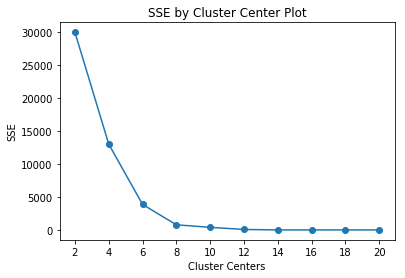

In [98]:
find_optimal_clusters(text, 20)

In [99]:
clusters = MiniBatchKMeans(n_clusters=6, init_size=1024, batch_size=2048, random_state=20).fit_predict(text)

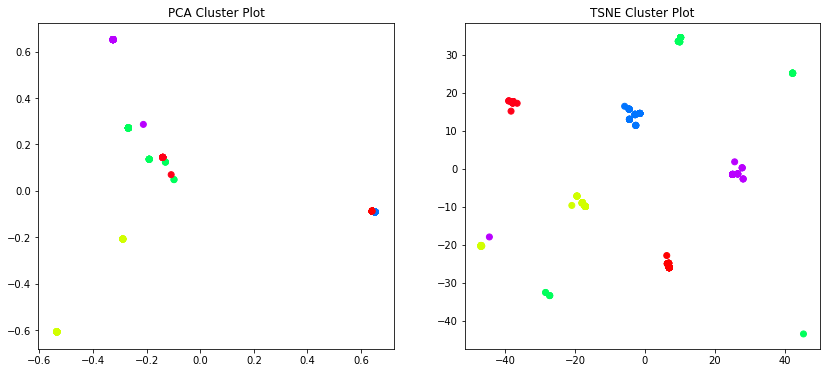

In [100]:
plot_tsne_pca(text, clusters)

In [101]:
get_top_keywords(text, clusters, tfidf.get_feature_names(), 6)


Cluster 0
rejected,saved,submitted,supervisor,payment,request

Cluster 1
supervisor,saved,rejected,declaration,submitted,employee

Cluster 2
missing,pre_approver,rejected,declaration,approved,administration

Cluster 3
request,saved,submitted,supervisor,payment,handled

Cluster 4
saved,submitted,rejected,declaration,final_approved,supervisor

Cluster 5
supervisor,rejected,declaration,approved,budget,owner


## How to choose the amount of events in a sequence

In [153]:
eval_df = df.groupby('case:id')['concept:name'].apply(list).reset_index(name="sequence")
eval_df["sequence"]

0        [Declaration SUBMITTED by EMPLOYEE, Declaration APPROVED by ADMINISTRATION, Declaration FINAL_APPROVED by SUPERVISOR, Request Payment, Payment Handled]                                                                                                                                                                                                                                                                
1        [Declaration SUBMITTED by EMPLOYEE, Declaration APPROVED by ADMINISTRATION, Declaration FINAL_APPROVED by SUPERVISOR, Request Payment, Payment Handled]                                                                                                                                                                                                                                                                
2        [Declaration SUBMITTED by EMPLOYEE, Declaration APPROVED by ADMINISTRATION, Declaration FINAL_APPROVED by SUPERVISOR, Request Payment, Payment Handled]      

(array([3.650e+02, 6.645e+03, 2.572e+03, 7.960e+02, 9.200e+01, 2.100e+01,
        6.000e+00, 2.000e+00, 0.000e+00, 1.000e+00]),
 array([ 1. ,  3.3,  5.6,  7.9, 10.2, 12.5, 14.8, 17.1, 19.4, 21.7, 24. ]),
 <a list of 10 Patch objects>)

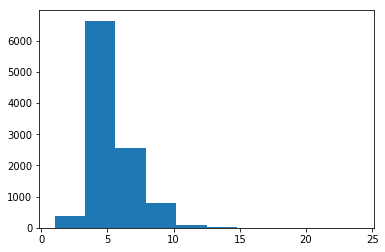

In [103]:
plt.hist(eval_df['sequence'].str.len())

In [182]:
eval_df["sequence_str"] = eval_df["sequence"].str.join(",")
eval_df

,case:id,sequence,sequence_str
0,declaration 100000,"[Declaration SUBMITTED by EMPLOYEE, Declaration APPROVED by ADMINISTRATION, Declaration FINAL_APPROVED by SUPERVISOR, Request Payment, Payment Handled]","Declaration SUBMITTED by EMPLOYEE,Declaration APPROVED by ADMINISTRATION,Declaration FINAL_APPROVED by SUPERVISOR,Request Payment,Payment Handled"
1,declaration 100005,"[Declaration SUBMITTED by EMPLOYEE, Declaration APPROVED by ADMINISTRATION, Declaration FINAL_APPROVED by SUPERVISOR, Request Payment, Payment Handled]","Declaration SUBMITTED by EMPLOYEE,Declaration APPROVED by ADMINISTRATION,Declaration FINAL_APPROVED by SUPERVISOR,Request Payment,Payment Handled"
2,declaration 100010,"[Declaration SUBMITTED by EMPLOYEE, Declaration APPROVED by ADMINISTRATION, Declaration FINAL_APPROVED by SUPERVISOR, Request Payment, Payment Handled]","Declaration SUBMITTED by EMPLOYEE,Declaration APPROVED by ADMINISTRATION,Declaration FINAL_APPROVED by SUPERVISOR,Request Payment,Payment Handled"
3,declaration 100015,"[Declaration SUBMITTED by EMPLOYEE, Declaration APPROVED by ADMINISTRATION, Declaration APPROVED by BUDGET OWNER, Declaration FINAL_APPROVED by SUPERVISOR, Request Payment, Payment Handled]","Declaration SUBMITTED by EMPLOYEE,Declaration APPROVED by ADMINISTRATION,Declaration APPROVED by BUDGET OWNER,Declaration FINAL_APPROVED by SUPERVISOR,Request Payment,Payment Handled"
4,declaration 100021,"[Declaration SUBMITTED by EMPLOYEE, Declaration APPROVED by ADMINISTRATION, Declaration APPROVED by BUDGET OWNER, Declaration FINAL_APPROVED by SUPERVISOR, Request Payment, Payment Handled]","Declaration SUBMITTED by EMPLOYEE,Declaration APPROVED by ADMINISTRATION,Declaration APPROVED by BUDGET OWNER,Declaration FINAL_APPROVED by SUPERVISOR,Request Payment,Payment Handled"
5,declaration 100027,"[Declaration SUBMITTED by EMPLOYEE, Declaration APPROVED by ADMINISTRATION, Declaration FINAL_APPROVED by SUPERVISOR, Request Payment, Payment Handled]","Declaration SUBMITTED by EMPLOYEE,Declaration APPROVED by ADMINISTRATION,Declaration FINAL_APPROVED by SUPERVISOR,Request Payment,Payment Handled"
6,declaration 100032,"[Declaration SUBMITTED by EMPLOYEE, Declaration APPROVED by ADMINISTRATION, Declaration FINAL_APPROVED by SUPERVISOR, Request Payment, Payment Handled]","Declaration SUBMITTED by EMPLOYEE,Declaration APPROVED by ADMINISTRATION,Declaration FINAL_APPROVED by SUPERVISOR,Request Payment,Payment Handled"
7,declaration 100037,"[Declaration SUBMITTED by EMPLOYEE, Declaration APPROVED by ADMINISTRATION, Declaration FINAL_APPROVED by SUPERVISOR, Request Payment, Payment Handled]","Declaration SUBMITTED by EMPLOYEE,Declaration APPROVED by ADMINISTRATION,Declaration FINAL_APPROVED by SUPERVISOR,Request Payment,Payment Handled"
8,declaration 100042,"[Declaration SUBMITTED by EMPLOYEE, Declaration APPROVED by ADMINISTRATION, Declaration APPROVED by BUDGET OWNER, Declaration FINAL_APPROVED by SUPERVISOR, Request Payment, Payment Handled]","Declaration SUBMITTED by EMPLOYEE,Declaration APPROVED by ADMINISTRATION,Declaration APPROVED by BUDGET OWNER,Declaration FINAL_APPROVED by SUPERVISOR,Request Payment,Payment Handled"
9,declaration 100048,"[Declaration SUBMITTED by EMPLOYEE, Declaration APPROVED by ADMINISTRATION, Declaration FINAL_APPROVED by SUPERVISOR, Request Payment, Payment Handled]","Declaration SUBMITTED by EMPLOYEE,Declaration APPROVED by ADMINISTRATION,Declaration FINAL_APPROVED by SUPERVISOR,Request Payment,Payment Handled"


In [190]:
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for col in ['sequence_str']:
        for sentence in data[col].iteritems():
            word_list = sentence[1].split(",")
            corpus.append(word_list)
            
    return corpus

corpus = build_corpus(eval_df)        
corpus[0:2]

[['Declaration SUBMITTED by EMPLOYEE',
  'Declaration APPROVED by ADMINISTRATION',
  'Declaration FINAL_APPROVED by SUPERVISOR',
  'Request Payment',
  'Payment Handled'],
 ['Declaration SUBMITTED by EMPLOYEE',
  'Declaration APPROVED by ADMINISTRATION',
  'Declaration FINAL_APPROVED by SUPERVISOR',
  'Request Payment',
  'Payment Handled']]

In [186]:
from gensim.models import word2vec

model = word2vec.Word2Vec(corpus, size=100, window=20, min_count=200, workers=4)
model.wv["Request Payment"]

array([ 0.00899721,  0.09123459,  0.07330539,  0.22459511,  0.07354723,
        0.00102833, -0.23595464, -0.15002993, -0.01332549,  0.30513766,
        0.09424731, -0.06754216, -0.03599268,  0.23918967,  0.11671891,
       -0.08712096, -0.02385871,  0.1295405 ,  0.19360428, -0.06048413,
        0.02611593, -0.06289225, -0.05122292, -0.00088849,  0.09434252,
        0.19685818,  0.04442687,  0.07342318, -0.1541062 ,  0.08889378,
        0.13000838, -0.07995482, -0.09425804,  0.23929282,  0.11671957,
       -0.03424442, -0.16720112,  0.16601901, -0.00613995,  0.1103441 ,
       -0.07798395,  0.28578678, -0.00617008, -0.12209706,  0.18577638,
       -0.05861841,  0.10950013, -0.16557173,  0.07446744, -0.01651431,
       -0.08159871,  0.093628  , -0.11751581,  0.18841343, -0.39492965,
       -0.05684759,  0.10235924,  0.1144833 ,  0.23619682,  0.27105933,
       -0.12331706, -0.04147654, -0.11424203,  0.0654742 ,  0.09738934,
       -0.18339281,  0.10429847, -0.00438457, -0.15821397,  0.23

In [187]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


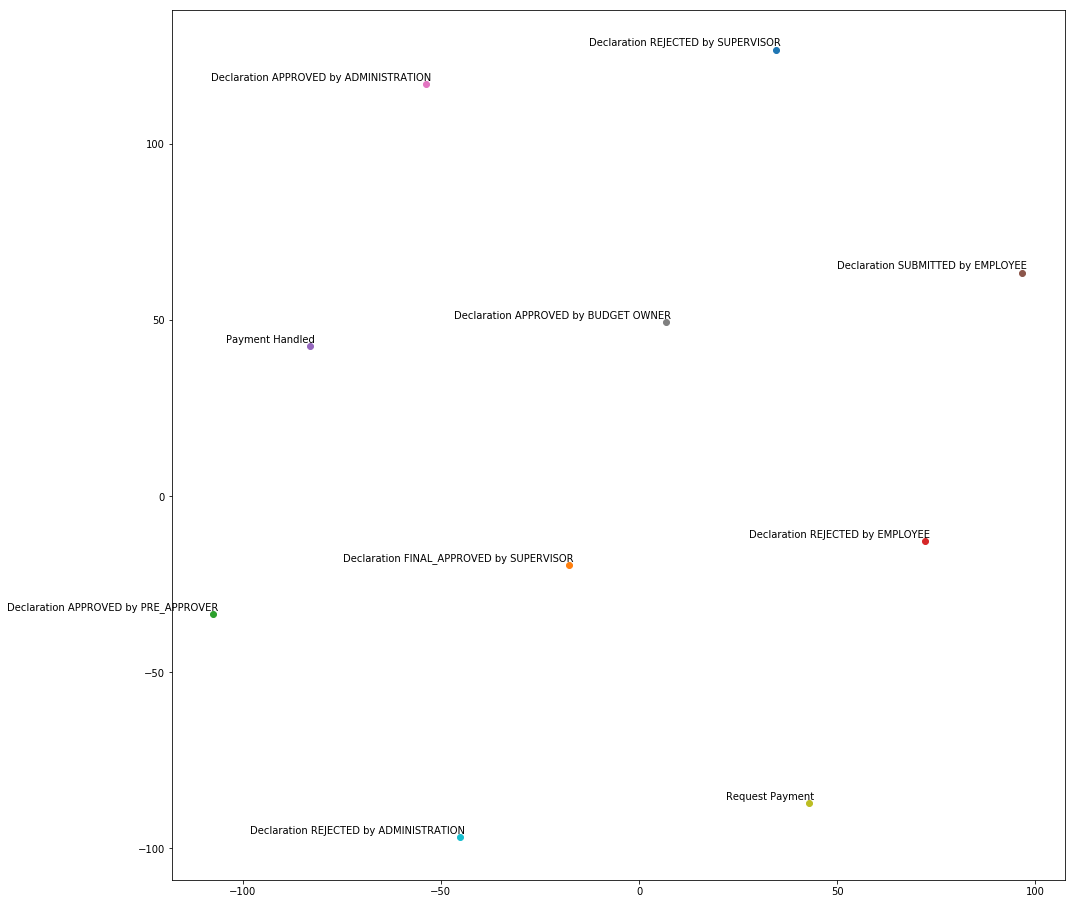

In [189]:
from sklearn.manifold import TSNE

tsne_plot(model)

## Create feature vector for each datapoint